In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [13]:
from options.test_options import TestOptions
from models import create_model
from data.knee_dataset import PixDataset
import sys
from ptoa.data.knee_monai import KneeDataset, Knee
import pandas as pd
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import torch
from matplotlib.lines import Line2D
import numpy as np
import argparse
import ast
import sklearn
import os

from myutil import load_opts, make_rgb, add_mask, plots, roi_combined, scale, dice_fn
from pred_cgan_dice import calc_dice

# Load Data

In [14]:
# HAKAN 2
df = pd.read_csv('/home/yua4/bip_submission/hakan_bmel_intra_nifti.csv', na_values='None')
df = df[df['base'] != 'comet-patient-ccf-015-20210920-knee']


In [15]:
knees_test = [Knee(base) for base in df['base']]

In [16]:
ds = PixDataset(img_size=320, knees=knees_test, task='translatebone')

SliceDataset.tx: 100%|███████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.84it/s]


# Options

In [17]:
opt = load_opts(
    '0128_100_translateall',
    epoch=500,
    num_threads = 0,   # test code only supports num_threads = 0
    batch_size = 1,    # test code only supports batch_size = 1
    serial_batches = True,  # disable data shuffling; comment this line if results on randomly chosen images are needed.
    no_flip = True,    # no flip; comment this line if results on flipped images are needed.
    display_id = -1,   # no visdom display; the test code saves the results to a HTML file.
    isTrain = False,
)
opt

Namespace(batch_size=1, beta1=0.5, checkpoints_dir='./checkpoints', continue_train=False, crop_size=320, dataroot='translateall', dataset_mode='aligned', direction='AtoB', display_env='main', display_freq=400, display_id=-1, display_ncols=4, display_port=8097, display_server='http://localhost', display_winsize=256, epoch=500, epoch_count=1, gan_mode='vanilla', gpu_ids=[0], init_gain=0.02, init_type='normal', input_nc=1, isTrain=False, lambda_L1=100.0, load_iter=0, load_size=320, lr=0.0005, lr_decay_iters=50, lr_policy='linear', max_dataset_size='inf', model='pix2pix', n_epochs=10000, n_epochs_decay=100, n_layers_D=3, name='0128_100_translateall', ndf=64, netD='n_layers', netG='unet_320', ngf=64, no_boneseg=False, no_dropout=False, no_flip=True, no_html=False, norm='batch', num_threads=0, output_nc=1, phase='train', pool_size=0, preprocess='resize_and_crop', print_freq=100, save_by_iter=False, save_epoch_freq=5, save_latest_freq=5000, serial_batches=True, suffix='', update_html_freq=100

In [18]:
ds.task = opt.dataroot
ds.img_size = opt.crop_size
dl = DataLoader(ds, batch_size=opt.batch_size, shuffle=False)

# Model

In [19]:
model = create_model(opt)
model.setup(opt)
model.eval()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# ALEATORIC UNCERTAINTY

# Viz

100%|████████████████████████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 1370.04it/s]


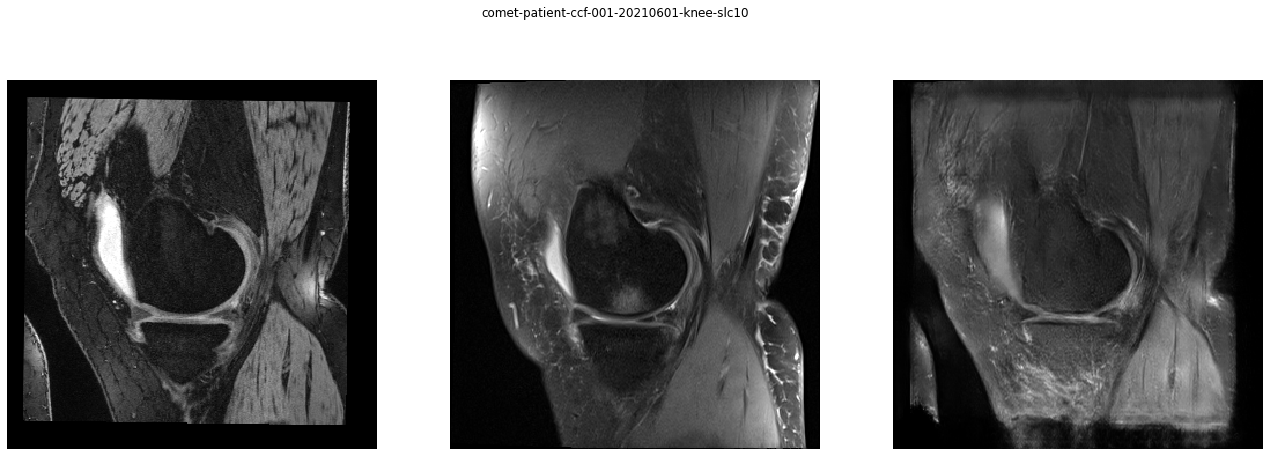

In [27]:
for data in tqdm.tqdm(dl):
    sample_ndx = 0
    if data['bmel'].sum() <= 0: continue
    # if data['base'][sample_ndx] != 'comet-patient-ccf-001-20210601-knee': continue
    if data['id'][sample_ndx] != 'comet-patient-ccf-001-20210601-knee-slc10': continue
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()
    real_dess = (visuals['real_A'][sample_ndx,0].detach().cpu().numpy() + 1) / 2
    fake_tse = (visuals['fake_B'][sample_ndx,0].detach().cpu().numpy() + 1) / 2
    real_tse = (visuals['real_B'][sample_ndx,0].detach().cpu().numpy() + 1) / 2
    bmel = data['bmel'][sample_ndx,0].detach().cpu().numpy()
    bone = data['bone'][sample_ndx,0].detach().cpu().numpy()
    mask = data['mask'][sample_ndx,0].detach().cpu().numpy()
    
    fig, ax = plots([real_dess, real_tse, fake_tse], cbar=False, axis=False)
    fig.suptitle(data['id'][sample_ndx])

In [ ]:
THRESHOLDS = np.arange(0, 0, 0.05)
N_MONTECARLO = 100

In [ ]:
dice_scores = []

for data in tqdm.tqdm(dl):
    # FILTER FOR DATA
    # if data['bmel'].sum() <= 0: continue
    if data['id'][sample_ndx] != 'comet-patient-ccf-001-20210601-knee-slc10': continue

    # GET DATA
    model.set_input(data)
    # model.test()
    # visuals = model.get_current_visuals()
    real_dess = (data['A'][sample_ndx,0].detach().cpu().numpy() + 1) / 2
    real_tse = (data['B'][sample_ndx,0].detach().cpu().numpy() + 1) / 2
    bmel = data['bmel'][sample_ndx,0].detach().cpu().numpy()
    bone = data['bone'][sample_ndx,0].detach().cpu().numpy()
    mask = data['mask'][sample_ndx,0].detach().cpu().numpy()
    # ALEATORIC
    fakes = []
    for i in range(N_MONTECARLO):
        model.forward()
        fake_B = (model.fake_B[0, 0].detach().cpu().numpy() + 1) / 2
        fakes.append(fake_B)
    fakes = np.stack(fakes, axis=0)
    aleatoric = scale(np.var(fakes, axis=0), new_min=1., new_max=10.)
    # aleatoric = 1.
    fake_tse = np.mean(fakes, axis=0)

    # INJECT POSTPROC HERE
    mask_roi_combined = roi_combined(bmel)

    epistemic = real_tse - fake_tse / aleatoric
    bmel_pred = epistemic
    bmel_pred = np.where(mask_roi_combined, bmel_pred, -1)
    bmel_pred = np.where(bone, bmel_pred, -1)

    for thresh in THRESHOLDS:
        bmel_pred_binary = bmel_pred > thresh
        dice_scores.append({
            'id': data['id'][sample_ndx],
            'base': data['base'][sample_ndx],
            'thresh': thresh,
            'dice': dice_fn(bmel_pred_binary.astype(bool), bmel.astype(bool)),
            'n_pixels_pred': bmel_pred_binary.astype(bool).sum(),
            'n_pixels_bmel': bmel.astype(bool).sum(),
            'n_pixels_intersect': (bmel_pred_binary.astype(bool) & bmel.astype(bool)).sum(),
        })
        plots([real_dess, real_tse, fake_tse, epistemic, bmel_pred_binary, aleatoric])
# dice_2d = pd.DataFrame(dice_scores)
# dices[run] = calc_dice(dice_2d)
# for k,v in dices[run].items():
#     print(f"{k}: {v:.4f}")

In [16]:
# 2D DICE
dice_2d = pd.DataFrame(dice_scores)
bmel_slices = (dice_2d['n_pixels_pred'] > 0) & (dice_2d['n_pixels_bmel'] > 0)

In [31]:
dice_2d

,id,base,thresh,dice,n_pixels_pred,n_pixels_bmel,n_pixels_intersect
0,comet-patient-ccf-001-20210601-knee_slc00,comet-patient-ccf-001-20210601-knee,-0.25,NaN,0,0,0
1,comet-patient-ccf-001-20210601-knee_slc00,comet-patient-ccf-001-20210601-knee,-0.24,NaN,0,0,0
2,comet-patient-ccf-001-20210601-knee_slc00,comet-patient-ccf-001-20210601-knee,-0.23,NaN,0,0,0
3,comet-patient-ccf-001-20210601-knee_slc00,comet-patient-ccf-001-20210601-knee,-0.22,NaN,0,0,0
4,comet-patient-ccf-001-20210601-knee_slc00,comet-patient-ccf-001-20210601-knee,-0.21,NaN,0,0,0
...,...,...,...,...,...,...,...
31445,moon-patient-vu-52391-20210913-knee_injured_slc32,moon-patient-vu-52391-20210913-knee_injured,0.20,NaN,0,0,0
31446,moon-patient-vu-52391-20210913-knee_injured_slc32,moon-patient-vu-52391-20210913-knee_injured,0.21,NaN,0,0,0
31447,moon-patient-vu-52391-20210913-knee_injured_slc32,moon-patient-vu-52391-20210913-knee_injured,0.22,NaN,0,0,0
31448,moon-patient-vu-52391-20210913-knee_injured_slc32,moon-patient-vu-52391-20210913-knee_injured,0.23,NaN,0,0,0


In [33]:
# 2D DICE, BMEL SLICES ONLY, BEST THRESH FOR EACH SLICE
(
    dice_2d[bmel_slices]
    .groupby('id').agg({'dice': 'max'})
    .mean().iloc[0]
)

0.24149331377935365

In [18]:
# 2D DICE, ALL SLICES, BEST THRESH FOR EACH SLICE
(
    dice_2d
    .groupby('id').agg({'dice': 'max'})
    .mean()
)

dice    0.075912
dtype: float64

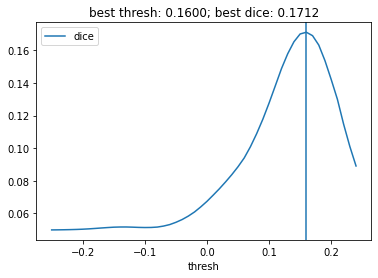

In [19]:
# 2D DICE, BMEL SLICES ONLY, BEST FOR ALL SLICES
dice_2d_thresh = (
    dice_2d[bmel_slices]
    .groupby('thresh').agg({'dice': 'mean'})
)
ax = dice_2d_thresh.plot()
ax.axvline(dice_2d_thresh['dice'].idxmax())
ax.set_title(f"best thresh: {dice_2d_thresh['dice'].idxmax():.4f}; best dice: {dice_2d_thresh['dice'].max():.4f}")
plt.show()

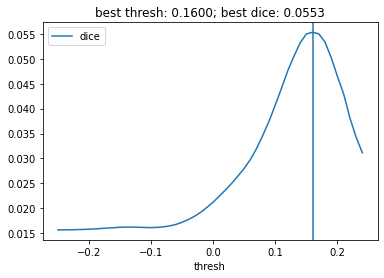

In [20]:
# 2D DICE, ALL SLICES, BEST FOR ALL SLICES
dice_2d_thresh = (
    dice_2d
    .groupby('thresh').agg({'dice': 'mean'})
)
ax = dice_2d_thresh.plot()
ax.axvline(dice_2d_thresh['dice'].idxmax())
ax.set_title(f"best thresh: {dice_2d_thresh['dice'].idxmax():.4f}; best dice: {dice_2d_thresh['dice'].max():.4f}")
plt.show()

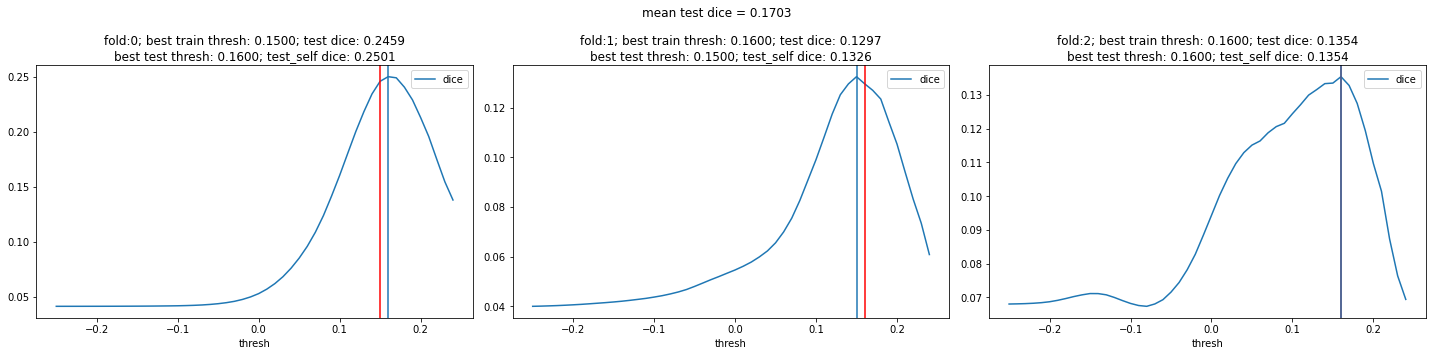

In [21]:
# 2D DICE, BMEL SLICES ONLY, THRESH FROM K-FOLD X-VAL
RANDOM_STATE=42
K=3
bases = dice_2d['base'].unique()
skf = sklearn.model_selection.StratifiedKFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)
fig, ax = plt.subplots(1, K, figsize=(20, 5))
dice_2d_fold = []
for i, (train_fold, test_fold) in enumerate(skf.split(dice_2d['base'].unique(), [b.split('-')[0] for b in bases])):
    best_thresh_train = (
        dice_2d[(bmel_slices) & (dice_2d['base'].isin(bases[train_fold]))]
        .groupby('thresh').agg({'dice': 'mean'})
        ['dice'].idxmax()
    )
    dice_2d_thresh_test = (
        dice_2d[(bmel_slices) & (dice_2d['base'].isin(bases[test_fold]))]
        .groupby('thresh').agg({'dice': 'mean'})
    )
    best_thresh_test = dice_2d_thresh_test['dice'].idxmax()
    dice_2d_test = dice_2d_thresh_test.pipe(lambda df: df[df.index == best_thresh_train].iloc[0]['dice'])
    dice_2d_test_self = dice_2d_thresh_test.pipe(lambda df: df[df.index == best_thresh_test].iloc[0]['dice'])
    dice_2d_thresh_test.plot(ax=ax[i])
    ax[i].axvline(best_thresh_train, c='r')
    ax[i].axvline(best_thresh_test)
    ax[i].set_title(f"fold:{i}; best train thresh: {best_thresh_train:.4f}; test dice: {dice_2d_test:.4f}\nbest test thresh: {best_thresh_test:.4f}; test_self dice: {dice_2d_test_self:.4f}")
    dice_2d_fold.append(dice_2d_test)
fig.suptitle(f'mean test dice = {np.array(dice_2d_fold).mean():.4f}')
fig.tight_layout()
plt.show()


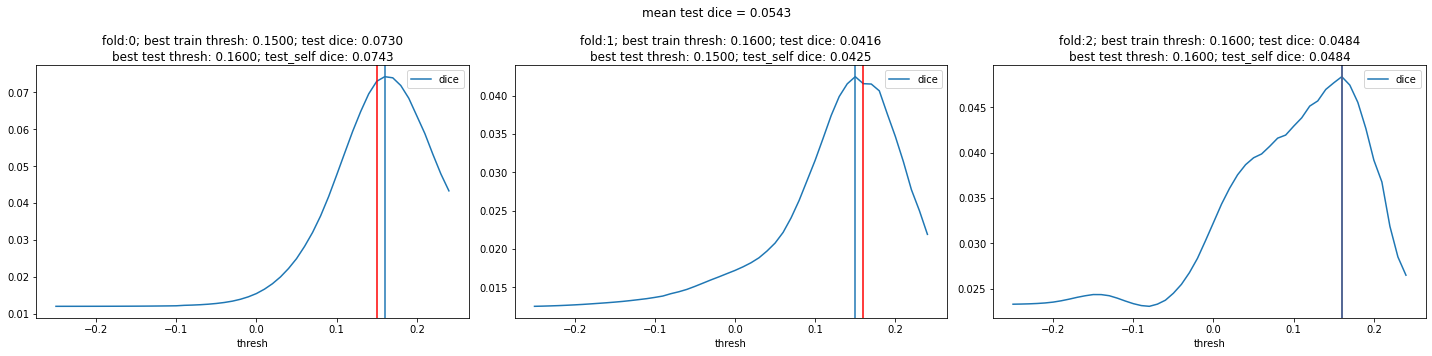

In [22]:
# 2D DICE, ALL SLICES, THRESH FROM K-FOLD X-VAL
RANDOM_STATE=42
K=3
bases = dice_2d['base'].unique()
skf = sklearn.model_selection.StratifiedKFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)
fig, ax = plt.subplots(1, K, figsize=(20, 5))
dice_2d_fold = []
for i, (train_fold, test_fold) in enumerate(skf.split(dice_2d['base'].unique(), [b.split('-')[0] for b in bases])):
    best_thresh_train = (
        dice_2d[(True) & (dice_2d['base'].isin(bases[train_fold]))]
        .groupby('thresh').agg({'dice': 'mean'})
        ['dice'].idxmax()
    )
    dice_2d_thresh_test = (
        dice_2d[(True) & (dice_2d['base'].isin(bases[test_fold]))]
        .groupby('thresh').agg({'dice': 'mean'})
    )
    best_thresh_test = dice_2d_thresh_test['dice'].idxmax()
    dice_2d_test = dice_2d_thresh_test.pipe(lambda df: df[df.index == best_thresh_train].iloc[0]['dice'])
    dice_2d_test_self = dice_2d_thresh_test.pipe(lambda df: df[df.index == best_thresh_test].iloc[0]['dice'])
    dice_2d_thresh_test.plot(ax=ax[i])
    ax[i].axvline(best_thresh_train, c='r')
    ax[i].axvline(best_thresh_test)
    ax[i].set_title(f"fold:{i}; best train thresh: {best_thresh_train:.4f}; test dice: {dice_2d_test:.4f}\nbest test thresh: {best_thresh_test:.4f}; test_self dice: {dice_2d_test_self:.4f}")
    dice_2d_fold.append(dice_2d_test)
fig.suptitle(f'mean test dice = {np.array(dice_2d_fold).mean():.4f}')
fig.tight_layout()
plt.show()


In [23]:
dice_3d_bmel = (
    dice_2d[bmel_slices]
    .groupby(['base', 'thresh'])
    .agg({'n_pixels_intersect': 'sum', 'n_pixels_pred': 'sum', 'n_pixels_bmel': 'sum','base': 'first'})
    .apply(lambda row: 2 * row['n_pixels_intersect'] / (row['n_pixels_pred'] + row['n_pixels_bmel']), axis=1)
    .reset_index(drop=False).rename(columns={0:'dice'})
)

In [24]:
dice_3d = (
    dice_2d
    .groupby(['base', 'thresh'])
    .agg({'n_pixels_intersect': 'sum', 'n_pixels_pred': 'sum', 'n_pixels_bmel': 'sum','base': 'first'})
    .apply(lambda row: 2 * row['n_pixels_intersect'] / (row['n_pixels_pred'] + row['n_pixels_bmel']), axis=1)
    .reset_index(drop=False).rename(columns={0:'dice'})
)

In [25]:
# 3D DICE, BMEL SLICES ONLY, BEST THRESH FOR EACH KNEE
(
    dice_3d_bmel
    .sort_values(['base', 'dice'])
    .groupby(['base'])
    .last()
)['dice'].mean()

0.22564323598476624

In [26]:
# 3D DICE, ALL SLICES, BEST THRESH FOR EACH KNEE
(
    dice_3d
    .sort_values(['base', 'dice'])
    .groupby(['base'])
    .last()
)['dice'].mean()

0.14202814029108646

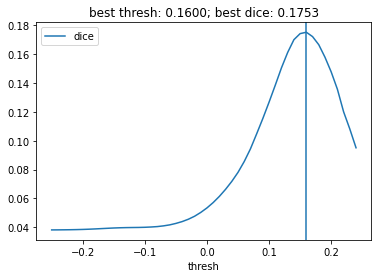

In [27]:
# 3D DICE, BMEL SLICES ONLY, BEST THRESH FOR ALL KNEES
dice_3d_bmel_thresh = (
    dice_3d_bmel
    .groupby('thresh')
    .agg({'dice': 'mean'})
)
ax = dice_3d_bmel_thresh.plot()
ax.axvline(dice_3d_bmel_thresh['dice'].idxmax())
ax.set_title(f"best thresh: {dice_3d_bmel_thresh['dice'].idxmax():.4f}; best dice: {dice_3d_bmel_thresh['dice'].max():.4f}")
plt.show()

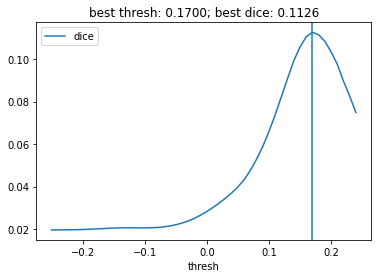

In [28]:
# 3D DICE, ALL SLICES, BEST THRESH FOR WHOLE SET
dice_3d_thresh = (
    dice_3d
    .groupby('thresh')
    .agg({'dice': 'mean'})
)
ax = dice_3d_thresh.plot()
ax.axvline(dice_3d_thresh['dice'].idxmax())
ax.set_title(f"best thresh: {dice_3d_thresh['dice'].idxmax():.4f}; best dice: {dice_3d_thresh['dice'].max():.4f}")
plt.show()

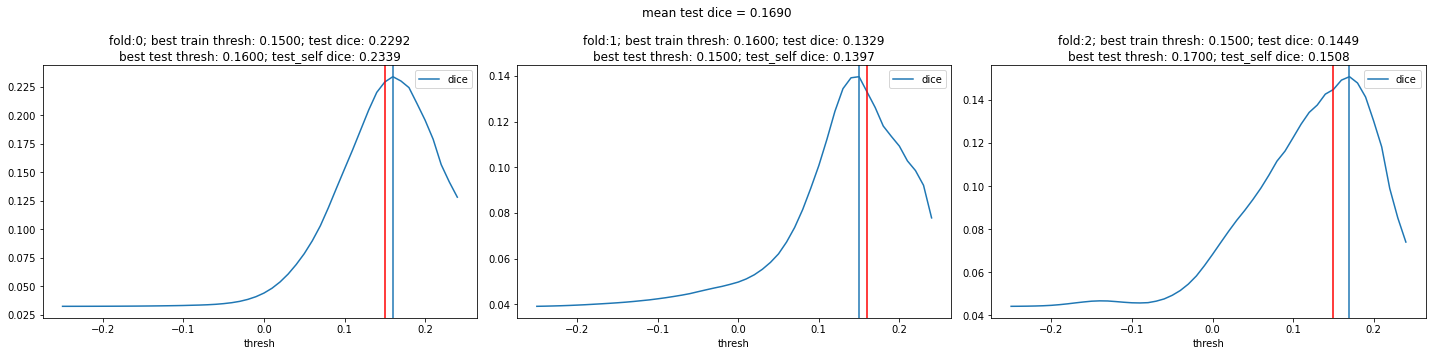

In [29]:
# 3D DICE, BMEL SLICES ONLY, THRESH FROM K-FOLD X-VAL
RANDOM_STATE=42
K=3
bases = dice_3d_bmel['base'].unique()
skf = sklearn.model_selection.StratifiedKFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)
fig, ax = plt.subplots(1, K, figsize=(20, 5))
dice_3d_bmel_fold = []
for i, (train_fold, test_fold) in enumerate(skf.split(dice_3d_bmel['base'].unique(), [b.split('-')[0] for b in bases])):
    best_thresh_train = (
        dice_3d_bmel[dice_3d_bmel['base'].isin(bases[train_fold])]
        .groupby('thresh').agg({'dice': 'mean'})
        ['dice'].idxmax()
    )
    dice_3d_bmel_thresh_test = (
        dice_3d_bmel[dice_3d_bmel['base'].isin(bases[test_fold])]
        .groupby('thresh').agg({'dice': 'mean'})
    )
    best_thresh_test = dice_3d_bmel_thresh_test['dice'].idxmax()
    dice_3d_bmel_test = dice_3d_bmel_thresh_test.pipe(lambda df: df[df.index == best_thresh_train].iloc[0]['dice'])
    dice_3d_bmel_test_self = dice_3d_bmel_thresh_test.pipe(lambda df: df[df.index == best_thresh_test].iloc[0]['dice'])
    dice_3d_bmel_thresh_test.plot(ax=ax[i])
    ax[i].axvline(best_thresh_train, c='r')
    ax[i].axvline(best_thresh_test)
    ax[i].set_title(f"fold:{i}; best train thresh: {best_thresh_train:.4f}; test dice: {dice_3d_bmel_test:.4f}\nbest test thresh: {best_thresh_test:.4f}; test_self dice: {dice_3d_bmel_test_self:.4f}")
    dice_3d_bmel_fold.append(dice_3d_bmel_test)
fig.suptitle(f'mean test dice = {np.array(dice_3d_bmel_fold).mean():.4f}')
fig.tight_layout()
plt.show()


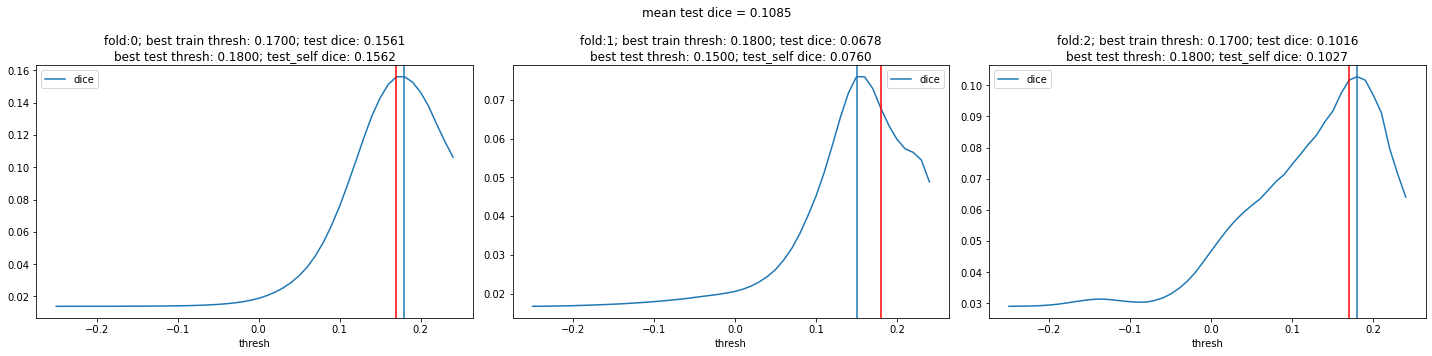

In [30]:
# 3D DICE, ALL SLICES, THRESH FROM K-FOLD X-VAL
RANDOM_STATE=42
K=3
bases = dice_3d['base'].unique()
skf = sklearn.model_selection.StratifiedKFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)
fig, ax = plt.subplots(1, K, figsize=(20, 5))
dice_3d_fold = []
for i, (train_fold, test_fold) in enumerate(skf.split(dice_3d['base'].unique(), [b.split('-')[0] for b in bases])):
    best_thresh_train = (
        dice_3d[dice_3d['base'].isin(bases[train_fold])]
        .groupby('thresh').agg({'dice': 'mean'})
        ['dice'].idxmax()
    )
    dice_3d_thresh_test = (
        dice_3d[dice_3d['base'].isin(bases[test_fold])]
        .groupby('thresh').agg({'dice': 'mean'})
    )
    best_thresh_test = dice_3d_thresh_test['dice'].idxmax()
    dice_3d_test = dice_3d_thresh_test.pipe(lambda df: df[df.index == best_thresh_train].iloc[0]['dice'])
    dice_3d_test_self = dice_3d_thresh_test.pipe(lambda df: df[df.index == best_thresh_test].iloc[0]['dice'])
    dice_3d_thresh_test.plot(ax=ax[i])
    ax[i].axvline(best_thresh_train, c='r')
    ax[i].axvline(best_thresh_test)
    ax[i].set_title(f"fold:{i}; best train thresh: {best_thresh_train:.4f}; test dice: {dice_3d_test:.4f}\nbest test thresh: {best_thresh_test:.4f}; test_self dice: {dice_3d_test_self:.4f}")
    dice_3d_fold.append(dice_3d_test)
fig.suptitle(f'mean test dice = {np.array(dice_3d_fold).mean():.4f}')
fig.tight_layout()
plt.show()


# READ `pred_cgan_dice.py`

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from options.test_options import TestOptions
from models import create_model
from data.knee_dataset import PixDataset
import sys
from ptoa.data.knee_monai import KneeDataset, Knee
import pandas as pd
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import torch
from matplotlib.lines import Line2D
import numpy as np
import argparse
import ast
import sklearn
import os

In [12]:
df = pd.read_csv('dice_df_noepsilon.csv').T.reset_index()
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.rename(columns={'Unnamed: 0': 'run'})
df[['task', 'epoch', 'lambda']]  = df['run'].str.split('_', expand=True)
df['epoch'] = df['epoch'].str.replace('E','').astype(int)
df['lambda'] = df['lambda'].str.replace('L','').astype(int)
df.head()
# df['run'].str.split('_')

,run,2d_bmel_each,2d_all_each,2d_bmel_one,2d_bmel_one_thresh,2d_all_one,2d_all_one_thresh,2d_bmel_xval,2d_all_xval,3d_bmel_each,3d_all_each,3d_bmel_one,3d_bmel_one_thresh,3d_all_one,3d_all_one_thresh,3d_bmel_xval,3d_all_xval,task,epoch,lambda
1,translateall_E0050_L10,0.256764,0.080713,0.188384,0.09,0.059849,0.09,0.18036,0.057103,0.229421,0.131579,0.185199,0.09,0.103834,0.11,0.181036,0.098992,translateall,50,10
2,translateall_E0050_L100,0.204141,0.064171,0.146135,0.13,0.046625,0.13,0.137505,0.042644,0.16926,0.104155,0.131815,0.14,0.083444,0.15,0.124245,0.078859,translateall,50,100
3,translatebone_E0050_L10,0.154413,0.048539,0.08777,0.07,0.027648,0.07,0.060599,0.019282,0.130516,0.067598,0.083132,0.07,0.040455,0.18,0.064823,0.023301,translatebone,50,10
4,translatebone_E0050_L100,0.270705,0.085095,0.165824,0.08,0.052682,0.08,0.152718,0.048383,0.246625,0.130697,0.170103,0.08,0.08481,0.11,0.155084,0.066777,translatebone,50,100
5,translateall_E0100_L10,0.261426,0.082178,0.172947,0.12,0.05518,0.12,0.165388,0.051422,0.231216,0.137629,0.16318,0.11,0.097646,0.13,0.133963,0.081809,translateall,100,10


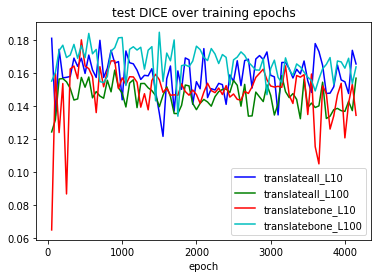

In [13]:
x = 'epoch'
y = '3d_bmel_xval'
colors = 'bgrcmykw'
fig,ax = plt.subplots()
for i, (task, lamb) in enumerate([('translateall', 10), ('translateall', 100), ('translatebone', 10), ('translatebone', 100)]):
        df[(df['task'] == task) & (df['lambda'] == lamb)][[x, y]].plot(x=x, y=y, ax=ax, label=f'{task}_L{lamb}', c=colors[i])
plt.legend()
plt.title('test DICE over training epochs')
plt.show()